<a href="https://colab.research.google.com/github/duanasq/learning-ds-public/blob/main/dl-fundamentals/residual_nets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise: Understand Residual Nets 

Generate a training set of periodic functions with different periods (e.g. sin(x), sin(2x) etc). Evaluate them on a regular grid (size n=1024). Input these into a FC neural network, and use the frequency as a label. Compare your results with a deep residual network.

In [1]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from torchsummary import summary
from sklearn.model_selection import train_test_split
import matplotlib.animation as animation

## Step 1. Generate training and test data

The first challenge was understanding what a single sample of data would look like. We decided a single sample would be a vector of length 1024 where each component was `sin(x)` or `sin(kx)` where `x` is between `-10*pi` and `10*pi` and k is the frequency which we will vary. Well, it's not technically the frequency as per the physics definition. To keep things simple, it is the parameter we want the neural net to learn.

TODO: How could we add noise to the data?

In [2]:
def dataset_generate(num_samples):
  size_image = 1024
  # we distinguish btw X and Y vs x and y: 
  # X is the collection of our data samples
  # Y is the collection of the corresponding labels
  # x is used to generate our sin values
  # y is the generated sin value
  X = []
  Y = []
  for i in range(num_samples):
    k = np.random.uniform(low = 0.1, high = 11) # this is the parameter we want to vary and get the NN to learn
    a = 1 #np.random.randn() # this is the amplitude - we will fix this now, but we could vary this in future too
    b = 0 #np.random.randn() # this is the y intercept. ditto
    x = np.linspace(-10*np.pi, 10 * np.pi, size_image) 
    y = a*np.sin(k*x) + b
    X.append(y)
    Y.append(k)
  return np.array(X), np.array(Y)


In [3]:
train_X, train_Y = dataset_generate(1000)
test_X, test_Y = dataset_generate(100)

(1000, 1024)
[ 0.99936036  0.99410489  0.96815553 ... -0.96815553 -0.99410489
 -0.99936036]
2.351138559835649


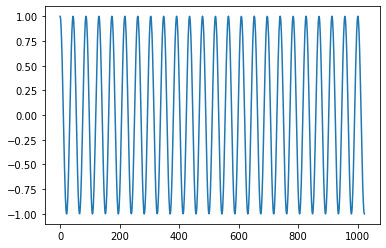

[-0.85699164 -0.97362818 -0.99671661 ...  0.99671661  0.97362818
  0.85699164]
5.067233075264055


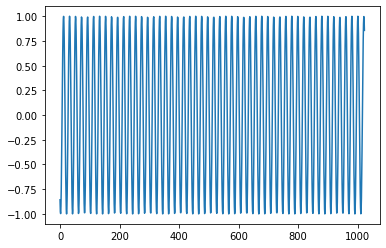

[-0.66825827 -0.74938365 -0.82056361 ...  0.82056361  0.74938365
  0.66825827]
1.8767040117584468


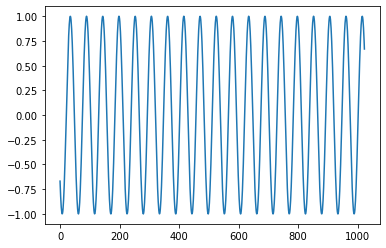

[ 0.53137954  0.65849927  0.76909092 ... -0.76909092 -0.65849927
 -0.53137954]
2.5821673819467685


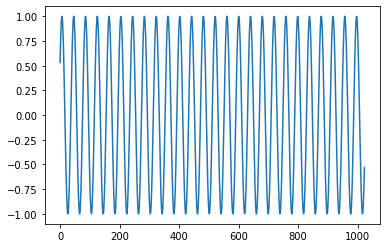

[-0.76534827 -0.36954992  0.11428282 ... -0.11428282  0.36954992
  0.76534827]
8.027743325293109


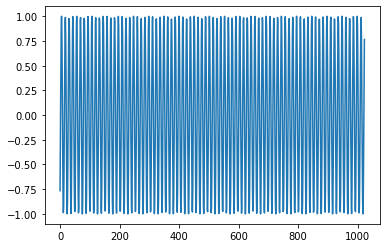

In [4]:
print(train_X.shape)

def display_samples(data, labels, num):
  for i in range(num):
    print(data[i])
    print(labels[i])
    plt.plot(data[i])
    plt.show()

display_samples(train_X, train_Y, 5)

## Step 2. Load data so it can be fed to model

In [5]:
# We have to first load them into Tensors. Tensors track the computations on the underlying multidimensional arrays 
train_tensor_x = torch.Tensor(train_X)
train_tensor_y = torch.Tensor(train_Y)
test_tensor_x = torch.Tensor(test_X)
test_tensor_y = torch.Tensor(test_Y)

In [6]:
# Now we load the Tensors into Datasets which is an abstraction that can hold samples and their labels
train_dataset = TensorDataset(train_tensor_x, train_tensor_y)
test_dataset = TensorDataset(test_tensor_x, test_tensor_y)

# Now we load the datasets into DataLoaders which is an abstraction to feed batches of data to the model
train_dataloader = DataLoader(train_dataset, batch_size=10)
test_dataloader = DataLoader(test_dataset, batch_size=10)

print("num training batches:\t", len(train_dataloader))
print("num training samples per batch:\t", len(train_dataloader.dataset))

num training batches:	 100
num training samples per batch:	 1000


## Step 3. Define a model

We will start with a model with a number of fully-connected layers.

In [7]:
def make_model():
  return nn.Sequential(nn.Linear(1024, 1024), nn.Tanh(), nn.Linear(1024, 1024), nn.Tanh(), nn.Linear(1024, 1), nn.Sigmoid())

In [9]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    train_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute predictions and then the loss (error) between the predictions and the actuals (labels). 
        # Since the input is tensors, these computations will be tracked by the tensor autograd framework.
        pred = model(X)
        loss = loss_fn(pred, y)

        # set the weights-and-biases gradients to zero for every new batch 
        # otherwise the calculations accumulate btw batches and the gradients will be wrong
        optimizer.zero_grad()
        # calculate the gradients on the weights-and-biases tensors (which is how the weights and biases contibute to the loss)
        loss.backward()
        # update the weights-and-biases to be a step in the opposite direction of their gradients
        optimizer.step()
        # add up the loss across batches
        train_loss += loss.item()

        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            #print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return train_loss / len(dataloader.dataset)

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader) 
    model.eval()
    test_loss, correct, relative_error = 0, 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            relative_error_temp = abs(y - pred) / abs(y)
            relative_error +=  relative_error_temp.type(torch.float).sum().item()
            #correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    relative_error /= size
    return test_loss
   # relative_error_final = relative_error.type(torch.float).sum().item()/ size
    #correct /= size

In [ ]:
def plot_model(model):
  arr = np.linspace(0, 1, num=500)[:, np.newaxis]
  x = torch.Tensor(arr)
  y = model(x).detach()
 # poly = np.poly1d([1, -28, 322, -1960, 6769, -13132, 13068, -540])
  y_real =  3* x[:,0] - 7#poly(arr)#5*x[:,0]**5 + 4*x[:,0]**4 + 3*x[:,0]**3 + 2*x[:,0]**2 + x[:,0] + 42 #3 * x[:,0] - 7
  #print('plotmodel')
  #print(x,y)
  df = pd.DataFrame(data = {"x": x[:, 0], "y": y[:, 0], "y_real": y_real}).melt(id_vars='x', value_vars=['y', 'y_real'])
  #print(df.head())
  sns.scatterplot(data = df, x='x', y='value', hue='variable')
  plt.show()


In [ ]:

def run_model(model):
  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
  print(model)

  epochs = 300
  for t in range(epochs):
      #print(f"Epoch {t+1}\n-------------------------------")
      train(train_dataloader, model, loss_fn, optimizer)
      test(test_dataloader, model, loss_fn)
  print("Done!")
  plot_model(model)

In [ ]:
import numpy as np

from matplotlib import pyplot as plt

noise_scale = 0.1

def dataset_generate(num_dataset):
  size_image = 32 * 32
  X = []
  Y = []
  for i in range(num_dataset):
    freq = np.random.uniform(low = 0.1, high = 11)
    a = 1 #np.random.randn()
    b = 0 #np.random.randn()
    x = np.linspace(-10*np.pi, 10 * np.pi, size_image) # + np.random.randn(size_image, 1)
    y = a*np.sin(freq *x) + b

    y += noise_scale*(np.random.random(1024) - 0.5)

    X.append(y)
    Y.append(freq)
    print(x)
    plt.plot(x,y)
    plt.show()

[-31.41592654 -31.35450732 -31.29308811 ...  31.29308811  31.35450732
  31.41592654]


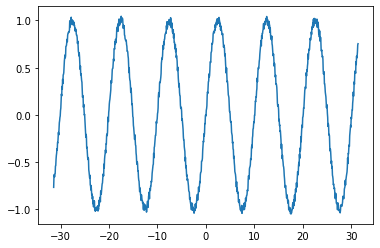

[-31.41592654 -31.35450732 -31.29308811 ...  31.29308811  31.35450732
  31.41592654]


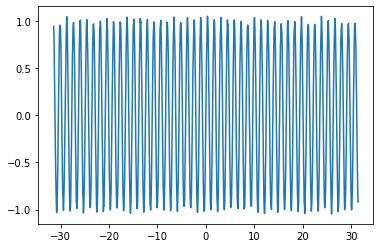

[-31.41592654 -31.35450732 -31.29308811 ...  31.29308811  31.35450732
  31.41592654]


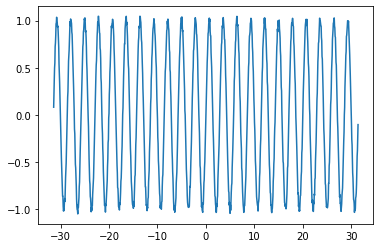

In [ ]:
dataset_generate(3)

In [ ]:
def dataset_generate2(num_dataset):
  noise_scale = 0.1
  feature_size = 1024
  a = 1
  b = 0
  Y = np.random.uniform(low = 0.1, high = 11, size=(num_dataset, 1))
  temp = np.linspace(-10*np.pi, 10 * np.pi, feature_size).reshape(1, feature_size)
  X = np.sin(Y * x) + noise_scale * (np.random.random((num_dataset, feature_size)) - 0.5)
  return X, Y

In [ ]:
Y = np.random.uniform(low = 0.1, high = 11, size=(1024, 1))

In [ ]:
x = np.linspace(-10*np.pi, 10 * np.pi, 1024).reshape(1,1024)

In [ ]:
A = np.sin(Y * x) + 0.1*(np.random.random((1000,1024)) - 0.5)
print(A.shape)


(1000, 1024)


In [ ]:
X,Y = dataset_generate2(5)
print(X.shape)
print(Y.shape)

(5, 1024)
(5, 1)
